# Use ONNX MaskRCNN

 In this notebook, we investigate how to use the [MaskRCNN](https://arxiv.org/abs/1703.06870) computer vision model serialized in [ONNX](https://onnx.ai/) format. For performing this experiment, we are using the "animal" dataset, which contains images of cute dogs and cats.

## Setup Environment

But before we start, let's set up our working environment. It will help us to keep the project directory clean. All artifacts generated within the project will be placed to the "tmp" directory and will be ignored by Git.

In [1]:
# Let's make a temporary directory for all artifacts created by this notebook.
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')

## Prepare Dataset

For creating the ML model we are loading the "animal" dataset which includes the following images:

| Photo           | Description                  |
| ----------------| ---------------------------- |
| cat-1.jpeg      | an image of a cat            |
| cat-2.jpeg      | an image of a cat            |
| cat-3.jpeg      | an image of a cat            |
| cat-m.jpeg      | an image of 5 cats           |
| dog-1.jpeg      | an image of a dog            |
| dog-2.jpeg      | an image of a dog            |
| dog-3.jpeg      | an image of a dog            |
| dog-m.jpeg      | an image of 3 dogs           |
| dog-n-cat.jpeg  | an image of 2 cats and 1 dog |

Please note, this data set is used for inference experiments only.

In [2]:
import numpy as np
from utils import load_dataset

# Sets the loading dataset name.
dataset_name = 'animal'

# Loads the dataset.
dataset = load_dataset(dataset_name)


## Download MaskRCNN ONNX Model

Use the following [page](https://github.com/onnx/models/tree/master/vision/classification/resnet) to get the URL for the ResNet ONNX model.

**Please note that downloading ONNX models have a large size. To prevent the repeated download of the same model on the notebook restart we check whether the model already exists. If a model exists we skip the download. To force download, go to the "tmp" directory and delete the "maskrcnn.onnx" file.**

In [3]:
if not os.path.exists(os.path.join('tmp', 'maskrcnn.onnx')):
    !wget -O tmp/maskrcnn.onnx https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/mask-rcnn/model/MaskRCNN-10.onnx
else:
    print('This notebook is using an already downloaded model.')
                      

This notebook is using an already downloaded model.


## Define Image Pre/Past-processors

Before and after using Mask RCNN, we need to process the images. The following two functions perform these actions. 

In [4]:
import cv2

from PIL import Image
from PIL import  ImageDraw

from matplotlib import pyplot as plt

import matplotlib.patches as patches

from utils import load_image

### Pre-process Image

In [5]:
def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

### Post-process Image

In [6]:
def postprocess(image, classes, boxes, labels, scores, masks, score_threshold=0.8):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    scaled_boxes = boxes / ratio

    image = np.array(image)
    overlay = image.copy()

    selected_boxes = []
    selected_labels = []
    selected_scores = []
    for mask, box, label, score in zip(masks, scaled_boxes, labels, scores):

        # Showing boxes with score > 0.7
        if score <= score_threshold:
            continue

        # Finding contour based on mask
        mask = mask[0, :, :, None]
        int_box = [int(i) for i in box]
        mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
        mask = mask > 0.5
        im_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        x_0 = max(int_box[0], 0)
        x_1 = min(int_box[2] + 1, image.shape[1])
        y_0 = max(int_box[1], 0)
        y_1 = min(int_box[3] + 1, image.shape[0])
        mask_y_0 = max(y_0 - box[1], 0)
        mask_y_1 = mask_y_0 + y_1 - y_0
        mask_x_0 = max(x_0 - box[0], 0)
        mask_x_1 = mask_x_0 + x_1 - x_0
        im_mask[y_0:y_1, x_0:x_1] = mask[
            mask_y_0 : mask_y_1, mask_x_0 : mask_x_1
        ]
        im_mask = im_mask[:, :, None]

        # OpenCV version 4.x
        contours, hierarchy = cv2.findContours(
            im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        alpha = 0.3
        cv2.fillPoly(overlay, contours,color=(128, 0, 128))
        cv2.addWeighted(overlay, alpha, image, 1 - alpha,0, image)

        selected_boxes.append(box)
        selected_labels.append(label)
        selected_scores.append(score)

    report = ""
    for box, label, score in zip(selected_boxes, selected_labels, selected_scores):
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (100,0,100), 2)
        image = cv2.putText(
            image,
            classes[label] + ':' + str(np.round(score, 2)),
            (int(box[0]), int(box[1]+10)),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            (255,255,255)
        )
        report += "%s: %s: %.2f\n" % (str(box), classes[label], score)

    return image, report

## Segment Images

First we need to load the model.

In [7]:
import onnxruntime as rt
sess = rt.InferenceSession(os.path.join('tmp', 'maskrcnn.onnx'))
classes = [line.rstrip('\n') for line in open(os.path.join('config', 'coco_classes.txt'))]

Load image for segmentation.

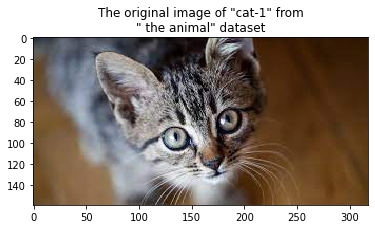

In [29]:
image_name = 'cat-1'
image = load_image(dataset_name, image_name)

fig, ax = plt.subplots()
plt.imshow(np.array(image), interpolation='nearest')
ax.set_title( f'The original image of "{image_name}" from\n" the {dataset_name}" dataset' )

plt.savefig(os.path.join('tmp', f'orig_{image_name.replace("-","_")}.jpg'))
plt.show()

Preprocess image for the MaskRCNN input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


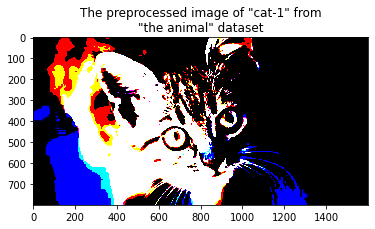

In [30]:
prep_image = preprocess(image)

fig, ax = plt.subplots()
plt.imshow(prep_image.transpose(1, 2, 0), interpolation='nearest')
ax.set_title( f'The preprocessed image of "{image_name}" from\n"the {dataset_name}" dataset' )

plt.savefig(os.path.join('tmp', f'maskrcnn_prep_{image_name.replace("-","_")}.jpg'))
plt.show()

Use ONNX model for segmentation.

In [10]:
boxes, labels, scores, masks = sess.run(
    None, {sess.get_inputs()[0].name: prep_image}
)

Selected Objects:
[122.71664   24.015398 196.43362  133.92918 ]: cat: 0.93
[170.58076   24.804388 266.99124  122.56846 ]: cat: 0.90
[  8.089327  36.001526  91.80778  118.99139 ]: dog: 0.89
[ 73.224495    0.2061126 137.0676    131.87912  ]: cat: 0.85
[ 79.838356   8.727741 183.24376  136.23697 ]: cat: 0.82



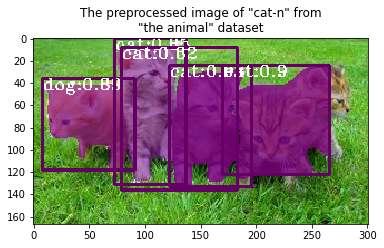

In [11]:
post_image, report = postprocess(image, classes, boxes, labels, scores, masks)

print('Selected Objects:\n%s'%report)

fig, ax = plt.subplots()
plt.imshow(post_image, interpolation='nearest')
ax.set_title( f'The preprocessed image of "{image_name}" from\n"the {dataset_name}" dataset' )

plt.savefig(os.path.join('tmp', f'maskrcnn_res_{image_name.replace("-","_")}.jpg'))
plt.show()